In [ ]:
import os
import time
import pandas as pd
import numpy as np

pd.set_option("display.max_columns", 100)
pd.set_option("display.width", 120)

# Paths 
RAW_DIR = os.path.join("..", "data", "raw")
CLEAN_DIR = os.path.join("..", "data", "cleaned")
os.makedirs(CLEAN_DIR, exist_ok=True)

FILE_NAME = "Banglore_traffic_Dataset.csv"  # change if your file is named differently
raw_path = os.path.join(RAW_DIR, FILE_NAME)

print("Raw file path:", raw_path)

In [ ]:
if not os.path.exists(raw_path):
    raise FileNotFoundError(f"Raw file not found at: {raw_path}")

df = pd.read_csv(raw_path)
print("✅ Raw data loaded.")
print("Shape:", df.shape)

df.head(3).T

In [ ]:
#– Define column mapping (canonical names). We’ll map your human-readable column names to internal/standard ones so later code is cleaner.
COLUMN_MAP = {
    "Date": "timestamp",
    "Area Name": "area",
    "Road/Intersection Name": "road",
    "Traffic Volume": "traffic_volume",
    "Average Speed": "avg_speed",
    "Travel Time Index": "travel_time_index",
    "Congestion Level": "congestion_level",
    "Road Capacity Utilization": "road_capacity_utilization",
    "Incident Reports": "incident_reports",
    "Environmental Impact": "environmental_impact",
    "Public Transport Usage": "public_transport_usage",
    "Traffic Signal Compliance": "traffic_signal_compliance",
    "Parking Usage": "parking_usage",
    "Pedestrian and Cyclist Count": "ped_cycle_count",
    "Weather Conditions": "weather",
    "Roadwork and Construction Activity": "roadwork"
}

missing_col=[c for c in COLUMN_MAP.keys() if c not in df.columns]
if len(missing_col) > 0:
    print('following Columns are not in df :', missing_col)
df_clean=df.rename(columns={a:b for a,b in COLUMN_MAP.items() if a in df.columns})
df_clean

In [ ]:
print("Shape before duplicate removal:", df_clean.shape)
dupes = df_clean.duplicated().sum() #Since subset parameters not provided it will look for duplicated rows inside the entire df.
print(f"Found {dupes} fully duplicated rows.")

if dupes > 0:
    df_clean = df_clean.drop_duplicates().reset_index(drop=True)

print("Shape after duplicate removal:", df_clean.shape)

#Timestamp Parsing and edge cases handling
if "timestamp" in df_clean.columns:
    df_clean["timestamp"] = pd.to_datetime(df_clean["timestamp"], errors="coerce") #error parameter is given to prevent the breaking of program flow.
    n_bad = df_clean["timestamp"].isna().sum()
    print(f"Failed to parse timestamp for {n_bad} rows.")
else:
    raise ValueError("No 'Date'/'timestamp' column found. Check COLUMN_MAP definitions.")

In [ ]:
# Drop rows with completely missing timestamp or location
before = df_clean.shape[0]
df_clean = df_clean.dropna(subset=["timestamp", "area", "road"])
after = df_clean.shape[0]
print(f"Dropped {before - after} rows with missing timestamp/area/road.")

# Derived date parts
# df_clean["hour"] = df_clean["timestamp"].dt.hour
# df_clean["dayofweek"] = df_clean["timestamp"].dt.dayofweek
df_clean["date"] = df_clean["timestamp"].dt.date
df_clean.head(3).T

In [ ]:
#– Standardize text columns
text_cols=df_clean.select_dtypes(include='object').columns.tolist()

for col in text_cols:
    if col in df_clean.columns:
        df_clean[col] = (
            df_clean[col]
            .astype(str)
            .str.strip()
            .replace({"nan": np.nan})  # if "nan" as string exists
        )
# For area & road, nicer title-case
        if col in ["area", "road"]:
            df_clean[col] = df_clean[col].str.title()
df_clean[text_cols].head()

In [ ]:
#– Numeric cleaning helpers
def to_numeric(series, colname):
    s = pd.to_numeric(series, errors="coerce")
    print(f"{colname}: {s.isna().sum()} values could not be converted to numeric and became NaN.")
    return s

num_cols = [
    "traffic_volume",
    "avg_speed",
    "travel_time_index",
    "road_capacity_utilization",
    "incident_reports",
    "environmental_impact",
    "public_transport_usage",
    "traffic_signal_compliance",
    "parking_usage",
    "ped_cycle_count"
]
for col in num_cols:
    if col in df_clean.columns:
        df_clean[col] = to_numeric(df_clean[col], col) #calling the above function

In [ ]:
#– Column-specific sanity rules
# 1. Average speed: no negatives, cap at 120 km/h (tune if needed)
if "avg_speed" in df_clean.columns:
    before_rows = len(df_clean)
    neg_speed = (df_clean["avg_speed"] < 0).sum()
    print(f"avg_speed: {neg_speed} negative values, setting to NaN.")
    df_clean.loc[df_clean["avg_speed"] < 0, "avg_speed"] = np.nan #data cleaning part
    
    # Cap extreme speeds
    too_high = (df_clean["avg_speed"] > 120).sum()
    print(f"avg_speed: {too_high} values >120 km/h, capping to 120.")
    df_clean.loc[df_clean["avg_speed"] > 120, "avg_speed"] = 120.0

# 2. Traffic volume: no negative counts, optionally cap very high outliers
if "traffic_volume" in df_clean.columns:
    neg_vol = (df_clean["traffic_volume"] < 0).sum()
    print(f"traffic_volume: {neg_vol} negative values, setting to NaN.")
    df_clean.loc[df_clean["traffic_volume"] < 0, "traffic_volume"] = np.nan
    
    # Cap at 99th percentile to reduce influence of extreme outliers
    q99 = df_clean["traffic_volume"].quantile(0.99)
    extreme = (df_clean["traffic_volume"] > q99).sum()
    print(f"traffic_volume: {extreme} values >99th percentile ({q99:.0f}), capping.")
    df_clean.loc[df_clean["traffic_volume"] > q99, "traffic_volume"] = q99

# 3. Percentage columns: force into [0, 100]
for perc_col in ["road_capacity_utilization", "public_transport_usage", 
                 "traffic_signal_compliance", "parking_usage"]:
    if perc_col in df_clean.columns:
        below0 = (df_clean[perc_col] < 0).sum()
        above100 = (df_clean[perc_col] > 100).sum()
        print(f"{perc_col}: {below0} <0, {above100} >100; clipping to [0,100].")
        
        df_clean.loc[df_clean[perc_col] < 0, perc_col] = 0
        df_clean.loc[df_clean[perc_col] > 100, perc_col] = 100

# 4. Incident and ped/cycle counts: no negatives
for count_col in ["incident_reports", "ped_cycle_count"]:
    if count_col in df_clean.columns:
        neg = (df_clean[count_col] < 0).sum()
        print(f"{count_col}: {neg} negative values, setting to NaN.")
        df_clean.loc[df_clean[count_col] < 0, count_col] = np.nan

# 5. Environmental impact: allow negatives? Usually no → set to NaN
if "environmental_impact" in df_clean.columns:
    neg_env = (df_clean["environmental_impact"] < 0).sum()
    print(f"environmental_impact: {neg_env} negative values, setting to NaN.")
    df_clean.loc[df_clean["environmental_impact"] < 0, "environmental_impact"] = np.nan


In [ ]:
#– Create a combined congestion score (helper metric). It will help later in identifying key tarffic hotspots. Part of feature Engineering
#-According to our analysis two columns ['travel_time_index','road_capacity_utilization'] that would be most contributing to the new metric.

if all(c in df_clean.columns for c in ["travel_time_index", "road_capacity_utilization"]):
    # Normalize travel_time_index to roughly 0–1 using min-max within data
    tti_min = df_clean["travel_time_index"].min()
    tti_max = df_clean["travel_time_index"].max()
    df_clean["tti_norm"] = (df_clean["travel_time_index"] - tti_min) / (tti_max - tti_min + 1e-6)  # 1e-6 is done to avoid division by zero 
    
    # road_capacity_utilization is already in [0,100]; make [0,1]
    df_clean["capacity_norm"] = df_clean["road_capacity_utilization"] / 100.0
    
    # Weighted score
    df_clean["congestion_score"] = (0.6 * df_clean["tti_norm"] + 0.4 * df_clean["capacity_norm"]).round(2)
    
    print("✅ Created congestion_score.")
else:
    print("⚠️ Could not create congestion_score; missing required columns.")

In [ ]:
#Geocoding- (lat/long) using geopy. We’ll geocode only unique (area, road) pairs to keep it efficient.
# Run this cell only if you have internet + geopy installed.
try:
    from geopy.geocoders import Nominatim
    from geopy.extra.rate_limiter import RateLimiter
    
    geolocator = Nominatim(user_agent="bengaluru_traffic_project")
    geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)  # respect usage limits
    
    print("✅ geopy imported, Nominatim geocoder ready.")
except Exception as e:
    print("⚠️ Could not import geopy or initialize geocoder:", e)


In [ ]:
#Checking the consistency of the dataset values:
df_clean['road'] = df_clean['road'].str.title().str.replace(" Rd", " Road")
df_clean['area'] = df_clean['area'].str.title()

# Build unique location table
location_cols = ["area", "road"]

for col in location_cols:
    if col not in df_clean.columns:
        raise ValueError(f"Missing required column for geocoding: {col}")

unique_locs = (
    df_clean[location_cols]
    .drop_duplicates()
    .reset_index(drop=True)
)

print("Unique (area, road) pairs:", len(unique_locs))
unique_locs

In [12]:
# Add lat/lon columns
unique_locs["lat"] = np.nan
unique_locs["lon"] = np.nan

def geocode_row(row):
    query = f"{row['road']}, {row['area']}, Bengaluru, India"
    try:
        location = geocode(query)
        if location:
            return pd.Series({"lat": location.latitude, "lon": location.longitude})
    except Exception as e:
        print("Geocoding error for", query, "→", e)
    return pd.Series({"lat": np.nan, "lon": np.nan})

# ⚠️ This may take a few minutes depending on number of unique locations.
for idx in range(len(unique_locs)):
    row = unique_locs.loc[idx, location_cols] #row-selection from unique_locs
    
    lat_lon = geocode_row(row) #calling the function and retrieving geo-coordinates

    unique_locs.loc[idx, ["lat", "lon"]] = lat_lon #updating nan values to actual geopoints
    if (idx + 1) % 20 == 0:
        print(f"Geocoded {idx + 1}/{len(unique_locs)} locations...")

unique_locs

,area,road,lat,lon
0,Indiranagar,100 Feet Road,12.975179,77.641074
1,Indiranagar,Cmh Road,12.978533,77.643749
2,Whitefield,Marathahalli Bridge,NaN,NaN
3,Koramangala,Sony World Junction,NaN,NaN
4,Koramangala,Sarjapur Road,12.924649,77.638278
5,M.G. Road,Trinity Circle,12.972652,77.619745
6,M.G. Road,Anil Kumble Circle,NaN,NaN
7,Jayanagar,Jayanagar 4Th Block,12.928559,77.582347
8,Jayanagar,South End Circle,NaN,NaN
9,Hebbal,Hebbal Flyover,13.041662,77.589944


In [ ]:
missing_geo = unique_locs["lat"].isna().sum()
print(f"Locations with missing geocode: {missing_geo} / {len(unique_locs)}")

In [ ]:
#Manually filling nan geo-coordinates:
manual = unique_locs[unique_locs["lat"].isna()][["area", "road"]].drop_duplicates() #only unique_entries
manual
#Export them for manual lookup:
manual.to_csv("manual_geo_lookup.csv", index=False)
print("✅ manual_geo_lookup.csv created")

In [ ]:
manual = pd.read_csv("manual_geo_lookup.csv")

#merge with existing unique_locs:
geo_data=unique_locs.merge(
    manual, how='left',on=['road','area']
)
geo_data['lat_x']=geo_data['lat_x'].fillna(geo_data['lat_y'])
geo_data['lon_x']=geo_data['lon_x'].fillna(geo_data['lon_y'])
geo_data.drop(columns=['lat_y','lon_y'],inplace=True)
geo_data.rename(columns={'lat_x' : 'latitude','lon_x':'longitude'},inplace=True)
geo_data

#final check before merging with main df
print("Remaining missing lat:", geo_data["latitude"].isna().sum())
print("Remaining missing lon:", geo_data["longitude"].isna().sum())


In [ ]:
#final merging and preparation of data for SQL:
df_final=df_clean.merge(
    geo_data, how='left',on=['area','road']
)

#Final Error Check
lat_err_count=df_final['latitude'].isna().sum()
lon_err_count=df_final['longitude'].isna().sum()
print(f'Total rows with missing latitude values:',lat_err_count)
print(f'Total rows with missing longitude values:',lon_err_count)

In [ ]:
#Save the final data
df_final.to_csv("../data/cleaned/traffic_cleaned_geo.csv", index=False)

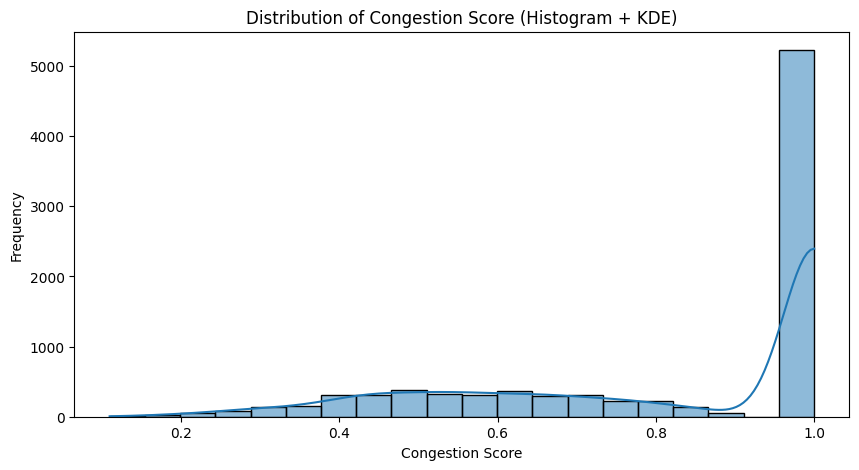

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import numpy as np

# Assuming df_clean is loaded and cleaned
plt.figure(figsize=(10, 5))
# Plot the histogram and the KDE plot on top
sns.histplot(df_clean['congestion_score'], kde=True, bins=20)
plt.title('Distribution of Congestion Score (Histogram + KDE)')
plt.xlabel('Congestion Score')
plt.ylabel('Frequency')
plt.show()

# Interpretation:
# If the peak is in the middle and tails are even, it's likely normal.
# If the peak is high on the right/left with a long tail on the other side, it's skewed.

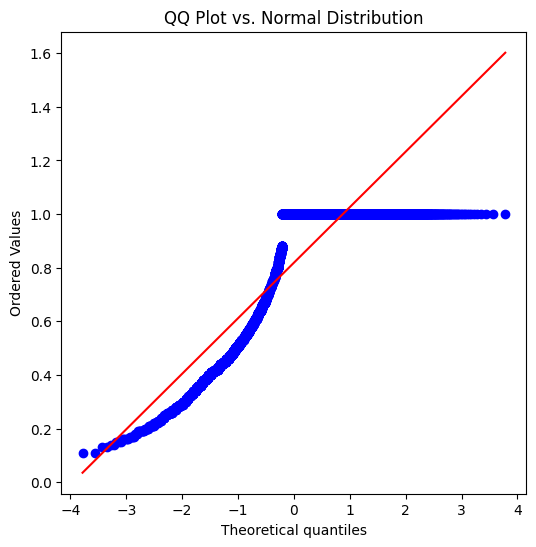

In [9]:
plt.figure(figsize=(6, 6))
stats.probplot(df_clean['congestion_score'], dist="norm", plot=plt)
plt.title('QQ Plot vs. Normal Distribution')
plt.show()

# Interpretation:
# If the data points form a straight diagonal line, the data is normally distributed.
# If the points curve away from the line, it is skewed or has heavy tails (outliers).